# Shelter Animal Outcomes

In [57]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import preprocessing

In [58]:
os.chdir(r'C:\Users\brcro\OneDrive\Documents\Syracuse\IST 652 - Scripting for Data Analysis\Project')
#os.chdir(r'C:\Users\Brandon Croarkin\Documents\Education\Syracuse\Scripting')

## Read in Data and Basic EDA 

In [59]:
# Austin Employment Data
pop = pd.ExcelFile('AustinEmployment.xlsx')
# Print the sheet names
print(pop.sheet_names)

['BLS Data Series']


In [60]:
#read Austin Employment data into a dataframe
pop_df = pd.DataFrame(pop.parse('BLS Data Series', skiprows = 12))
pop_df.set_index('Year', inplace = True)
pop_df.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2008,788.8,792.1,790.5,790.3,790.1,789.9,791.4,792.8,794.3,791.9,791.3,789.4
2009,784.9,781.2,777.3,775.4,774.7,772.4,771.9,771.0,769.9,769.7,770.3,771.1
2010,775.2,776.4,780.8,780.6,783.2,785.0,786.1,787.3,787.7,793.3,795.1,797.6
2011,799.4,802.2,805.0,809.7,808.9,810.8,812.9,816.1,819.3,817.6,820.2,824.4
2012,829.5,830.1,833.2,835.3,837.6,842.0,843.6,848.4,852.3,856.1,859.8,863.5


In [61]:
#convert wide format into long format that is more suitable for analysis
years = []
months = []
data = []
for year in pop_df.index:
    for col in pop_df.columns:
        years.append(year)
        months.append(col)
        data.append(pop_df.loc[year][col])
df = pd.DataFrame({'Year': years, 
                   'Month': months,
                  'Employment': data})    
df.head()

,Employment,Month,Year
0,788.8,Jan,2008
1,792.1,Feb,2008
2,790.5,Mar,2008
3,790.3,Apr,2008
4,790.1,May,2008


In [62]:
#use mapping to convert the Months to an integer
month_mapping = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
df['Month'] = df['Month'].map(month_mapping)

In [122]:
#Read in Shelter Data. Going to just use the training data for this project. 
train = pd.read_csv('train.csv')
train.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [64]:
#Explore the shape of the data
train.shape

(26729, 10)

In [65]:
#view the columns included
train.columns

Index(['AnimalID', 'Name', 'DateTime', 'OutcomeType', 'OutcomeSubtype',
       'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color'],
      dtype='object')

In [66]:
train[train.OutcomeType == 'Transfer']['OutcomeSubtype'].value_counts()

Partner    7816
SCRP       1599
Barn          1
Name: OutcomeSubtype, dtype: int64

In [67]:
train[train.OutcomeType == 'Euthanasia']['OutcomeSubtype'].value_counts()

Suffering              1002
Aggressive              320
Behavior                 86
Rabies Risk              74
Medical                  66
Court/Investigation       6
Name: OutcomeSubtype, dtype: int64

In [68]:
train[train.OutcomeType == 'Return_to_owner']['OutcomeSubtype'].value_counts()

Series([], Name: OutcomeSubtype, dtype: int64)

In [69]:
train[train.OutcomeType == 'Adoption']['OutcomeSubtype'].value_counts()

Foster     1800
Offsite     165
Barn          1
Name: OutcomeSubtype, dtype: int64

In [70]:
train[train.OutcomeType == 'Died']['OutcomeSubtype'].value_counts()

In Kennel     114
In Foster      52
Enroute         8
At Vet          4
In Surgery      3
Name: OutcomeSubtype, dtype: int64

In [71]:
print(np.min(train.DateTime), np.max(train.DateTime))

2013-10-01 09:31:00 2016-02-21 19:17:00


In [72]:
colors = train.Color.value_counts()
colors[:25]

Black/White            2824
Black                  2292
Brown Tabby            1635
Brown Tabby/White       940
White                   931
Brown/White             884
Orange Tabby            841
Tan/White               773
Tricolor                752
Blue/White              702
Black/Tan               672
White/Black             643
Brown                   639
Tan                     628
White/Brown             569
Tortie                  530
Calico                  517
Orange Tabby/White      455
Blue                    450
Brown Brindle/White     450
Black/Brown             436
Blue Tabby              433
White/Tan               389
Red                     337
Torbie                  335
Name: Color, dtype: int64

In [73]:
train.groupby('AnimalType').Breed.value_counts(ascending = False)

AnimalType  Breed                                      
Cat         Domestic Shorthair Mix                         8810
            Domestic Medium Hair Mix                        839
            Domestic Longhair Mix                           520
            Siamese Mix                                     389
            Domestic Shorthair                              143
            Snowshoe Mix                                     75
            Maine Coon Mix                                   44
            Manx Mix                                         44
            Domestic Medium Hair                             42
            Russian Blue Mix                                 33
            Siamese                                          24
            Domestic Longhair                                23
            Himalayan Mix                                    15
            Persian Mix                                      12
            Ragdoll Mix                         

In [74]:
print(len(train[train['AnimalType'] == 'Dog'].Breed.unique()))
train[train['AnimalType'] == 'Dog'].Breed.value_counts(ascending = False)

1320


Pit Bull Mix                                  1906
Chihuahua Shorthair Mix                       1766
Labrador Retriever Mix                        1363
German Shepherd Mix                            575
Australian Cattle Dog Mix                      367
Dachshund Mix                                  318
Boxer Mix                                      245
Miniature Poodle Mix                           233
Border Collie Mix                              229
Australian Shepherd Mix                        163
Rat Terrier Mix                                157
Catahoula Mix                                  157
Jack Russell Terrier Mix                       146
Yorkshire Terrier Mix                          143
Chihuahua Longhair Mix                         142
Siberian Husky Mix                             138
Miniature Schnauzer Mix                        136
Beagle Mix                                     124
Rottweiler Mix                                 113
American Bulldog Mix           

In [75]:
train['SexuponOutcome'].unique()

array(['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female',
       'Unknown', nan], dtype=object)

In [76]:
train['AgeuponOutcome'].unique()

array(['1 year', '2 years', '3 weeks', '1 month', '5 months', '4 years',
       '3 months', '2 weeks', '2 months', '10 months', '6 months',
       '5 years', '7 years', '3 years', '4 months', '12 years', '9 years',
       '6 years', '1 weeks', '11 years', '4 weeks', '7 months', '8 years',
       '11 months', '4 days', '9 months', '8 months', '15 years',
       '10 years', '1 week', '0 years', '14 years', '3 days', '6 days',
       '5 days', '5 weeks', '2 days', '16 years', '1 day', '13 years',
       nan, '17 years', '18 years', '19 years', '20 years'], dtype=object)

In [77]:
train['OutcomeType'].value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

In [78]:
train.describe()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A699262,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


## Clean Data 

In [79]:
train.dtypes

AnimalID          object
Name              object
DateTime          object
OutcomeType       object
OutcomeSubtype    object
AnimalType        object
SexuponOutcome    object
AgeuponOutcome    object
Breed             object
Color             object
dtype: object

In [80]:
#Find Missing Values
train.isna().sum()

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

In [81]:
#Remove missing values 
train = train.dropna(subset = ['AgeuponOutcome'])
train = train.dropna(subset = ['SexuponOutcome'])
train.isna().sum()

AnimalID              0
Name               7673
DateTime              0
OutcomeType           0
OutcomeSubtype    13611
AnimalType            0
SexuponOutcome        0
AgeuponOutcome        0
Breed                 0
Color                 0
dtype: int64

In [82]:
#Remove unneeded columns (AnimalID and Name)
train.drop(['AnimalID', 'Name'], axis=1, inplace=True)

In [83]:
#Change data types
train['OutcomeType'] = train['OutcomeType'].astype('category')
train['OutcomeSubtype'] = train['OutcomeSubtype'].astype('category')
train['AnimalType'] = train['AnimalType'].astype('category')
train['Breed'] = train['Breed'].astype('category')
train['DateTime'] = pd.to_datetime(train['DateTime'])

In [84]:
#View updated data types
train.dtypes

DateTime          datetime64[ns]
OutcomeType             category
OutcomeSubtype          category
AnimalType              category
SexuponOutcome            object
AgeuponOutcome            object
Breed                   category
Color                     object
dtype: object

## Feature Engineering

In [85]:
#Create function to split Neutered into two fields
def NG_split(x):
        if x != 'Unknown':
            Neutered, Gender = x.split()
            if Neutered == 'Intact':
                Neutered == False
            else:
                Neutered == True
        else:
            Neutered = None
            Gender = None
        return(Neutered, Gender)

In [86]:
Neutered = []
Gender = []
for val in train['SexuponOutcome']:
    neutered, gender = NG_split(val)
    Neutered.append(neutered)
    Gender.append(gender)
train['Neutered'] = Neutered
#convert spayed to neutered to track together
neuter_mapping = {'Neutered': 'Neutered', 'Spayed': 'Neutered', 'Intact': 'Intact', None: None}
train['Neutered'] = train['Neutered'].map(neuter_mapping)
train['Gender'] = Gender
train = train.drop('SexuponOutcome', 1)
train.head()

,DateTime,OutcomeType,OutcomeSubtype,AnimalType,AgeuponOutcome,Breed,Color,Neutered,Gender
0,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,1 year,Shetland Sheepdog Mix,Brown/White,Neutered,Male
1,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,1 year,Domestic Shorthair Mix,Cream Tabby,Neutered,Female
2,2015-01-31 12:28:00,Adoption,Foster,Dog,2 years,Pit Bull Mix,Blue/White,Neutered,Male
3,2014-07-11 19:09:00,Transfer,Partner,Cat,3 weeks,Domestic Shorthair Mix,Blue Cream,Intact,Male
4,2013-11-15 12:52:00,Transfer,Partner,Dog,2 years,Lhasa Apso/Miniature Poodle,Tan,Neutered,Male


In [87]:
#Create function to convert age string into a number
def agetodays(x):
        try:
            if x == 'Unknown':
                return None
            else:
                y = x.split()
        except:
            return None 
        if 'year' in y[1]:
            return float(y[0]) * 365
        elif 'month' in y[1]:
            return float(y[0]) * (365/12)
        elif 'week' in y[1]:
            return float(y[0]) * 7
        elif 'day' in y[1]:
            return float(y[0])
        
train['Age'] = train['AgeuponOutcome'].map(agetodays)
train.drop('AgeuponOutcome', axis = 'columns', inplace = True)
train.head()

,DateTime,OutcomeType,OutcomeSubtype,AnimalType,Breed,Color,Neutered,Gender,Age
0,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Shetland Sheepdog Mix,Brown/White,Neutered,Male,365.0
1,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Domestic Shorthair Mix,Cream Tabby,Neutered,Female,365.0
2,2015-01-31 12:28:00,Adoption,Foster,Dog,Pit Bull Mix,Blue/White,Neutered,Male,730.0
3,2014-07-11 19:09:00,Transfer,Partner,Cat,Domestic Shorthair Mix,Blue Cream,Intact,Male,21.0
4,2013-11-15 12:52:00,Transfer,Partner,Dog,Lhasa Apso/Miniature Poodle,Tan,Neutered,Male,730.0


In [88]:
#Drop Missing Age values
train = train.dropna(subset=['Age', 'Neutered', 'Gender'])
train.isna().sum()

DateTime              0
OutcomeType           0
OutcomeSubtype    13594
AnimalType            0
Breed                 0
Color                 0
Neutered              0
Gender                0
Age                   0
dtype: int64

In [89]:
colors = train.Color.value_counts()
def colorCategories(color):
    if colors[color] < 50:
        color = 'Other'
    else:
        color = color
    return(color)

train['Color'] = train['Color'].map(colorCategories)
train.head()

,DateTime,OutcomeType,OutcomeSubtype,AnimalType,Breed,Color,Neutered,Gender,Age
0,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Shetland Sheepdog Mix,Brown/White,Neutered,Male,365.0
1,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Domestic Shorthair Mix,Cream Tabby,Neutered,Female,365.0
2,2015-01-31 12:28:00,Adoption,Foster,Dog,Pit Bull Mix,Blue/White,Neutered,Male,730.0
3,2014-07-11 19:09:00,Transfer,Partner,Cat,Domestic Shorthair Mix,Other,Intact,Male,21.0
4,2013-11-15 12:52:00,Transfer,Partner,Dog,Lhasa Apso/Miniature Poodle,Tan,Neutered,Male,730.0


In [90]:
#Create new date fields
train['Year'] = train['DateTime'].dt.year
train['Month'] = train['DateTime'].dt.month
train['Day'] = train['DateTime'].dt.day

,OutcomeType,OutcomeSubtype,AnimalType,Breed,Color,Neutered,Gender,Age,Year,Month,Day
0,Return_to_owner,NaN,Dog,Shetland Sheepdog Mix,Brown/White,Neutered,Male,365.000000,2014,2,12
1,Euthanasia,Suffering,Cat,Domestic Shorthair Mix,Cream Tabby,Neutered,Female,365.000000,2013,10,13
2,Adoption,Foster,Dog,Pit Bull Mix,Blue/White,Neutered,Male,730.000000,2015,1,31
3,Transfer,Partner,Cat,Domestic Shorthair Mix,Other,Intact,Male,21.000000,2014,7,11
4,Transfer,Partner,Dog,Lhasa Apso/Miniature Poodle,Tan,Neutered,Male,730.000000,2013,11,15
5,Transfer,Partner,Dog,Cairn Terrier/Chihuahua Shorthair,Black/Tan,Intact,Female,30.416667,2014,4,25
6,Transfer,Partner,Cat,Domestic Shorthair Mix,Blue Tabby,Intact,Male,21.000000,2015,3,28
8,Adoption,NaN,Dog,American Pit Bull Terrier Mix,Red/White,Neutered,Female,152.083333,2014,2,4
9,Adoption,Offsite,Dog,Cairn Terrier,White,Neutered,Female,365.000000,2014,5,3
11,Adoption,NaN,Dog,Miniature Schnauzer Mix,Other,Neutered,Female,730.000000,2013,11,4


In [91]:
#Merge with Austin Employment data
df_train = pd.merge(train, df)
df_train.head()

,DateTime,OutcomeType,OutcomeSubtype,AnimalType,Breed,Color,Neutered,Gender,Age,Year,Month,Day,Employment
0,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Shetland Sheepdog Mix,Brown/White,Neutered,Male,365.000000,2014,2,12,909.9
1,2014-02-04 17:17:00,Adoption,NaN,Dog,American Pit Bull Terrier Mix,Red/White,Neutered,Female,152.083333,2014,2,4,909.9
2,2014-02-11 18:16:00,Return_to_owner,NaN,Dog,Beagle Mix,Tricolor,Neutered,Male,1825.000000,2014,2,11,909.9
3,2014-02-16 19:38:00,Adoption,Offsite,Cat,Domestic Medium Hair Mix,Cream Tabby,Neutered,Male,304.166667,2014,2,16,909.9
4,2014-02-10 12:34:00,Return_to_owner,NaN,Dog,Dachshund Longhair,Brown,Neutered,Female,730.000000,2014,2,10,909.9


## EDA 

C:\Users\brcro\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Age (in days)')

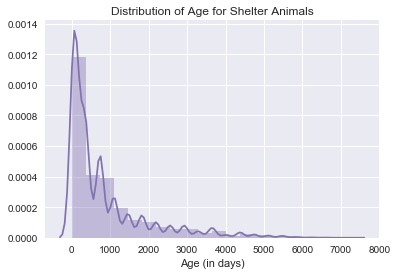

In [114]:
#Age distribution
sns.set(color_codes=True)
df_train['Age'] = df_train['Age'].astype(float)
sns.distplot(df_train['Age'], bins = 20, color = 'm')
plt.title('Distribution of Age for Shelter Animals')
plt.xlabel('Age (in days)')

In [124]:
#What is the mean of shelter animal age?
print(df_train.Age.mean())
print(df_train.Age.mean() / 365.0)
print(df_train.Age.median())

819.1475677504156
2.2442399116449745
365.0


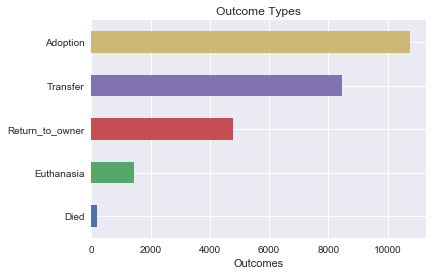

In [115]:
#Outcome Types Chart
df_train['OutcomeType'].value_counts(ascending = True).plot(kind = 'barh')
plt.title('Outcome Types')
plt.xlabel('Count')
plt.xlabel('Outcomes')
plt.show()

In [121]:
#Outcome Types
df_train['OutcomeType'].value_counts(ascending = False, normalize = True)

Adoption           0.420319
Transfer           0.330003
Return_to_owner    0.186292
Euthanasia         0.056672
Died               0.006713
Name: OutcomeType, dtype: float64

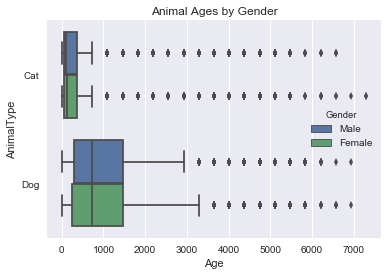

In [94]:
#Boxplot of Ages by Animal and gender
sns.boxplot(data=df_train,
         x='Age',
         y='AnimalType',
            hue = 'Gender')

plt.title('Animal Ages by Gender')
plt.show()

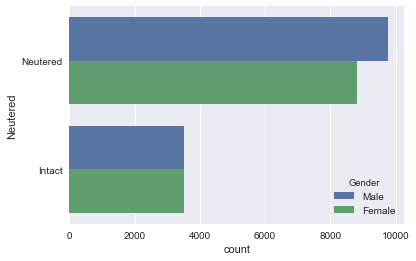

In [95]:
#Count plot of Neutered by Male and Female animals
sns.countplot(data = df_train,
             y = "Neutered",
             hue = "Gender")
plt.show()

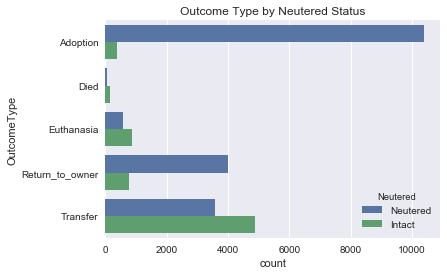

In [96]:
#Count plot of Neutered by Male and Female animals
sns.countplot(data = df_train,
             y = "OutcomeType",
             hue = "Neutered")
plt.title('Outcome Type by Neutered Status')
plt.show()

In [97]:
#Make a pivot table for Outcome Types by month (can use random value for Values since just a count)
adoptions_df = pd.pivot_table(df_train, index = 'Month', columns = 'OutcomeType', values = 'Age', aggfunc = 'count')
adoptions_df

OutcomeType,Adoption,Died,Euthanasia,Return_to_owner,Transfer
Month,,,,,
1,1045,11,114,507,612
2,819,10,103,412,464
3,571,6,103,336,419
4,500,7,91,377,599
5,686,15,115,366,727
6,830,21,143,331,794
7,1151,24,138,317,790
8,955,16,102,298,708
9,780,12,101,307,698


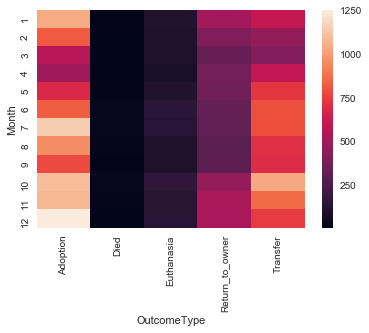

In [98]:
#Create a heatmap of the pivot table
sns.heatmap(adoptions_df)

In [99]:
#Make a pivot table for Outcome Types by month and year
adoptions_df2 = pd.pivot_table(df_train, index = ['Year','Month'], columns = 'OutcomeType', values = 'Age', aggfunc = 'count').dropna()
adoptions_df2

OutcomeType  Adoption  Died  Euthanasia  Return_to_owner  Transfer
Year Month                                                        
2013 10         359.0  12.0        72.0            148.0     370.0
     11         342.0   3.0        47.0            143.0     260.0
     12         427.0   1.0        57.0            141.0     286.0
2014 1          313.0   3.0        46.0            152.0     216.0
     2          261.0   3.0        41.0            139.0     194.0
     3          285.0   2.0        53.0            165.0     267.0
     4          270.0   4.0        46.0            188.0     314.0
     5          301.0   8.0        46.0            155.0     395.0
     6          378.0   8.0        66.0            158.0     409.0
     7          579.0  14.0        79.0            148.0     461.0
     8          497.0   5.0        59.0            142.0     380.0
     9          369.0   4.0        61.0            155.0     377.0
     10         382.0   2.0        61.0            141.0     334.0
     11         320.0   4.0        68.0            153.0     307.0
     12         403.0   7.0        61.0            183.0     250.0
2015 1          340.0   4.0        49.0            170.0     178.0
     2          287.0   3.0        47.0            153.0     157.0
     3          286.0   4.0        50.0            171.0     152.0
     4          230.0   3.0        45.0            189.0     285.0
     5          385.0   7.0        69.0            211.0     332.0
     6          452.0  13.0        77.0            173.0     385.0
     7          572.0  10.0        59.0            169.0     329.0
     8          458.0  11.0        43.0            156.0     328.0
     9          411.0   8.0        40.0            152.0     321.0
     10         360.0  10.0        32.0            183.0     333.0
     11         419.0   9.0        22.0            232.0     298.0
     12         420.0   2.0        22.0            198.0     206.0
2016 1          392.0   4.0        19.0            185.0     218.0
     2          271.0   4.0        15.0            120.0     113.0

In [100]:
#Find row totals
#I got errors when I tried to add a column, so over-writing instead
adoptions_df3 = adoptions_df2.copy()
adoptions_df3['Adoption'] = adoptions_df2.sum(axis = 1)
adoptions_df3.drop(['Died', 'Euthanasia', 'Return_to_owner', 'Transfer'], axis = 1, inplace = True)
adoptions_df3 = adoptions_df3.rename(columns = {'Adoption': 'Total'})
adoptions_df3.reset_index(inplace = True)
adoptions_df3.head()

OutcomeType,Year,Month,Total
0,2013,10,961.0
1,2013,11,795.0
2,2013,12,912.0
3,2014,1,730.0
4,2014,2,638.0


In [101]:
#merge with Austin Employment data
#reset index of df so they are matching
df.reset_index(inplace = True)
#Merge two files
df_PopAdop = pd.merge(adoptions_df3, df,  how='left', left_on=['Year','Month'], right_on = ['Year','Month'])
df_PopAdop['Day'] = 1
df_PopAdop['DateTime'] = pd.to_datetime(df_PopAdop[['Year', 'Month', 'Day']])
df_PopAdop.drop(['Year', 'Month', 'Day', 'index'], axis = 1, inplace = True)
#df_PopAdop.set_index('DateTime', inplace = True)
df_PopAdop.head()

,Total,Employment,DateTime
0,961.0,894.8,2013-10-01
1,795.0,898.0,2013-11-01
2,912.0,901.8,2013-12-01
3,730.0,905.4,2014-01-01
4,638.0,909.9,2014-02-01


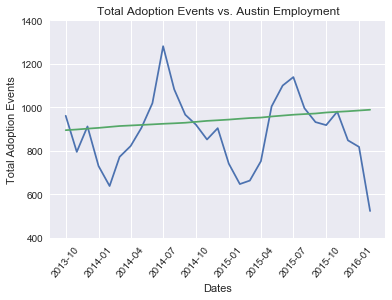

In [102]:
#Plot results
fig = plt.figure()
ax = plt.axes()
ax.set_ylim([400, 1400])
plt.xticks(rotation=50)
plt.title('Total Adoption Events vs. Austin Employment')
plt.xlabel('Dates')
plt.ylabel('Total Adoption Events')

plt.plot(df_PopAdop.DateTime, df_PopAdop.Total)
plt.plot(df_PopAdop.DateTime, df_PopAdop.Employment)

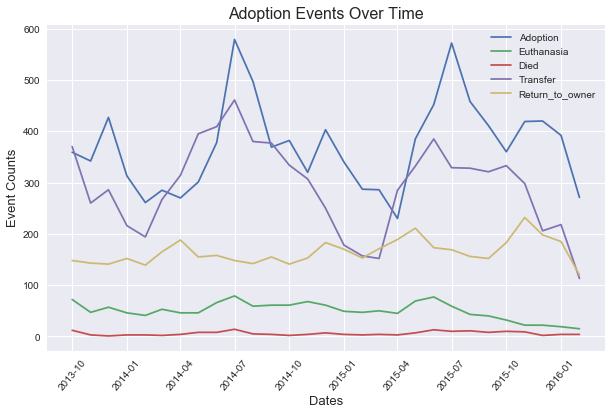

In [103]:
#Show the different Adoption Events over time
fig = plt.figure(figsize = (10, 6))
ax = plt.axes()
plt.xticks(rotation=50)
plt.title('Adoption Events Over Time', fontsize = 16)
plt.xlabel('Dates', fontsize = 13)
plt.ylabel('Event Counts', fontsize = 13)

plt.plot(df_PopAdop.DateTime, adoptions_df2.Adoption)
plt.plot(df_PopAdop.DateTime, adoptions_df2.Euthanasia)
plt.plot(df_PopAdop.DateTime, adoptions_df2.Died)
plt.plot(df_PopAdop.DateTime, adoptions_df2.Transfer)
plt.plot(df_PopAdop.DateTime, adoptions_df2.Return_to_owner)
plt.legend(prop = {'size': 10})

C:\Users\brcro\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


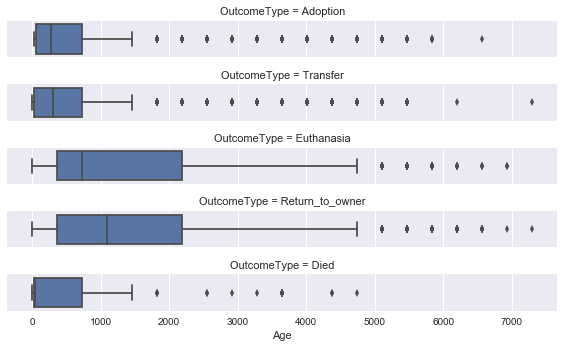

In [104]:
# Create FacetGrid with OutcomeType
g2 = sns.FacetGrid(df_train, 
                   row="OutcomeType",
                   row_order=['Adoption', 'Transfer', 'Euthanasia', 'Return_to_owner', 'Died'],
                   size = 1, 
                   aspect = 8 )

# Map a boxplot of Age onto the grid
g2.map(sns.boxplot, 'Age')

# Show the plot
plt.show()

## Predictive Analytics 

In [105]:
#Subset to only Adoption and Euthanasia as OutcomeType as these are the variables of interest. 
df_preds = df_train[(df_train['OutcomeType'] == 'Adoption') | (df_train['OutcomeType'] == 'Euthanasia')]
#Drop DateTime (repetitive) and OutcomeSubtype (confounding variable)
df_preds.drop('OutcomeSubtype', axis = 1, inplace = True)
df_preds.drop('DateTime', axis = 1, inplace = True)
df_preds.head()

C:\Users\brcro\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\brcro\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,OutcomeType,AnimalType,Breed,Color,Neutered,Gender,Age,Year,Month,Day,Employment
1,Adoption,Dog,American Pit Bull Terrier Mix,Red/White,Neutered,Female,152.083333,2014,2,4,909.9
3,Adoption,Cat,Domestic Medium Hair Mix,Cream Tabby,Neutered,Male,304.166667,2014,2,16,909.9
6,Adoption,Dog,Cardigan Welsh Corgi/Cardigan Welsh Corgi,Fawn/White,Neutered,Male,273.750000,2014,2,14,909.9
12,Adoption,Dog,Labrador Retriever/Standard Poodle,Black,Neutered,Male,243.333333,2014,2,11,909.9
18,Adoption,Cat,Domestic Longhair Mix,Gray/White,Neutered,Male,2920.000000,2014,2,3,909.9


In [106]:
###CONVERT CATEGORICALS TO BINARY WITH ONE-HOT ENCODING
# limit to categorical data using df.select_dtypes()
x = df_preds.iloc[:,0:].select_dtypes(exclude=["number"])
#Convert Categorical Data to One-Hot Encoded columns
le = preprocessing.LabelEncoder()
# use df.apply() to apply le.fit_transform to all columns
x2 = x.apply(le.fit_transform)
x2.head()

,OutcomeType,AnimalType,Breed,Color,Neutered,Gender
1,0,1,29,38,1,0
3,0,0,445,24,1,1
6,0,1,266,27,1,1
12,0,1,628,0,1,1
18,0,0,442,31,1,1


In [107]:
#combine dataframe with numeric values
df_preds = pd.concat([x2, df_preds.iloc[:,0:].select_dtypes(include=["number"])], axis=1)
df_preds.head()

,OutcomeType,AnimalType,Breed,Color,Neutered,Gender,Age,Year,Month,Day,Employment
1,0,1,29,38,1,0,152.083333,2014,2,4,909.9
3,0,0,445,24,1,1,304.166667,2014,2,16,909.9
6,0,1,266,27,1,1,273.750000,2014,2,14,909.9
12,0,1,628,0,1,1,243.333333,2014,2,11,909.9
18,0,0,442,31,1,1,2920.000000,2014,2,3,909.9


In [108]:
#Create Training and Test Split
x = df_preds.iloc[:,1:]
y = df_preds['OutcomeType']
train_data,test_data,train_label,test_label = train_test_split(x, y, test_size=0.2, random_state=42)

### Random Forest

In [109]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

In [110]:
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(train_data,train_label)

preds=clf.predict(test_data)

In [111]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_label, preds))

Accuracy: 0.9292433537832311


In [112]:
#Find Important Features
feature_imp = pd.Series(clf.feature_importances_,index=train_data.columns).sort_values(ascending=False)
feature_imp

Neutered      0.357568
Age           0.178389
Day           0.110242
Color         0.094948
Breed         0.092770
Employment    0.067654
Month         0.053825
Gender        0.017560
Year          0.015214
AnimalType    0.011830
dtype: float64

No handles with labels found to put in legend.


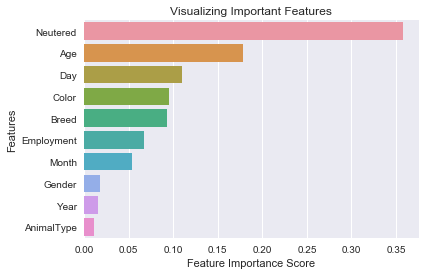

In [113]:
#Visualizing Important Features
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()